In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import os, time, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Mounted at /content/drive
Using device: cuda


In [ ]:

DATA_DIR = "/content/drive/MyDrive/tokenized_subset"
BIN_DIR  = os.path.join(DATA_DIR, "bin")
os.makedirs(BIN_DIR, exist_ok=True)

TRAIN_TXT = os.path.join(DATA_DIR, "train.txt")
VAL_TXT   = os.path.join(DATA_DIR, "val.txt")
TEST_TXT  = os.path.join(DATA_DIR, "test.txt")
files = {
    "TRAIN_TXT": TRAIN_TXT,
    "VAL_TXT": VAL_TXT,
    "TEST_TXT": TEST_TXT
}

for name, path in files.items():
    if os.path.exists(path):
        print(f"{name} exists at: {path}")
    else:
        print(f"{name} does NOT exist at: {path}")


TRAIN_TXT exists at: /content/drive/MyDrive/tokenized_subset/train.txt
VAL_TXT exists at: /content/drive/MyDrive/tokenized_subset/val.txt
TEST_TXT exists at: /content/drive/MyDrive/tokenized_subset/test.txt


In [ ]:
import os
import numpy as np
import json

def encode_file(txt_path, bin_path, vocab_path):
    if os.path.exists(bin_path):
        print(f"{bin_path} already exists, skipping.")
        return

    with open(vocab_path, "r") as f:
        vocab = json.load(f)

    print(f"Encoding {txt_path} -> {bin_path}")
    tokens = []
    with open(txt_path, "r") as f:
        for line in f:
            ids = [int(tok) for tok in line.strip().split()]
            tokens.extend(ids)

    np_tokens = np.array(tokens, dtype=np.uint32)
    np_tokens.tofile(bin_path)
    print(f"Saved {bin_path}, total tokens: {len(tokens)}")



VOCAB_PATH = os.path.join(DATA_DIR, "vocab.json")
TRAIN_BIN = os.path.join(BIN_DIR, "train.bin")
VAL_BIN   = os.path.join(BIN_DIR, "val.bin")
TEST_BIN  = os.path.join(BIN_DIR, "test.bin")

encode_file(TRAIN_TXT, TRAIN_BIN, VOCAB_PATH)
encode_file(VAL_TXT, VAL_BIN, VOCAB_PATH)
encode_file(TEST_TXT, TEST_BIN, VOCAB_PATH)


/content/drive/MyDrive/tokenized_subset/bin/train.bin already exists, skipping.
/content/drive/MyDrive/tokenized_subset/bin/val.bin already exists, skipping.
/content/drive/MyDrive/tokenized_subset/bin/test.bin already exists, skipping.


In [ ]:
BIN_DIR  = os.path.join(DATA_DIR, "bin")

TRAIN_BIN = os.path.join(BIN_DIR, "train.bin")
VAL_BIN   = os.path.join(BIN_DIR, "val.bin")
VOCAB_PATH = os.path.join(DATA_DIR, "vocab.json")
assert os.path.exists(TRAIN_BIN), f"Missing: {TRAIN_BIN}"
assert os.path.exists(VAL_BIN),   f"Missing: {VAL_BIN}"
print("Found train/val bin files ✅")

Found train/val bin files ✅


In [ ]:

with open(VOCAB_PATH, "r") as f:
    vocab = json.load(f)
vocab_size = len(vocab)

print("Vocab size:", vocab_size)

Vocab size: 1734


In [ ]:
class BinDataset:
    def __init__(self, path, block_size):
        self.data = np.memmap(path, dtype=np.uint32, mode="r")
        self.block_size = block_size

    def get_batch(self, batch_size, device):
        ix = torch.randint(len(self.data) - self.block_size - 1, (batch_size,))
        x = torch.stack([
            torch.from_numpy(self.data[i:i+self.block_size].astype(np.int64))
            for i in ix
        ])
        y = torch.stack([
            torch.from_numpy(self.data[i+1:i+self.block_size+1].astype(np.int64))
            for i in ix
        ])
        return x.to(device), y.to(device)


In [ ]:
block_size = 256
batch_size = 8

train_data = BinDataset(TRAIN_BIN, block_size)
val_data   = BinDataset(VAL_BIN, block_size)

total_train_tokens = len(train_data.data)
steps_per_epoch = total_train_tokens // (batch_size * block_size)

print("Total train tokens:", total_train_tokens)
print("Steps per epoch:", steps_per_epoch)


Total train tokens: 140459152
Steps per epoch: 68583


In [ ]:
class LSTMLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.ln = nn.LayerNorm(hidden_size)
        self.head = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, targets=None):
        x = self.embed(x)
        out, _ = self.lstm(x)
        out = self.ln(out)
        logits = self.head(out)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1)
            )
        return logits, loss


In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters()) / 1e6


In [ ]:
def train_one_rnn(cfg, train_data, val_data):
    model = LSTMLM(**cfg).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=3e-4,
        betas=(0.9, 0.95),
        weight_decay=0.1
    )

    warmup_steps = int(0.05 * steps_per_epoch)
    min_lr = 3e-5

    def get_lr(step):
        if step < warmup_steps:
            return 3e-4 * step / warmup_steps
        progress = (step - warmup_steps) / (steps_per_epoch - warmup_steps)
        return max(min_lr, 3e-4 * 0.5 * (1 + math.cos(math.pi * progress)))

    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()

    model.train()
    for step in range(steps_per_epoch):
        lr = get_lr(step)
        for pg in optimizer.param_groups:
            pg["lr"] = lr

        xb, yb = train_data.get_batch(batch_size, device)
        _, loss = model(xb, yb)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        if step % 5000 == 0:
            print(f"step {step} | lr {lr:.2e} | loss {loss.item():.4f}")


    model.eval()
    val_losses = []
    with torch.no_grad():
        for _ in range(500):
            xb, yb = val_data.get_batch(batch_size, device)
            _, loss = model(xb, yb)
            val_losses.append(loss.item())

    stats = {
        "params_M": count_params(model),
        "val_loss": sum(val_losses) / len(val_losses),
        "time_min": (time.time() - start_time) / 60,
        "peak_mem_MB": torch.cuda.max_memory_allocated() / 1024**2
    }

    del model
    torch.cuda.empty_cache()
    return stats


In [ ]:
transformer_targets = {
    "Tiny":   3.39,
    "Small":  7.27,
    "Medium": 22.73,
    "Large":  52.35,
    "XL":     100.86,
}

In [ ]:
import math

def find_best_lstm_configs(vocab_size, targets, hidden_candidates, layer_candidates):
    best = {}

    for tname, target_M in targets.items():
        best_item = None

        for h in hidden_candidates:
            for L in layer_candidates:
                cfg = dict(
                    vocab_size=vocab_size,
                    embed_dim=h,
                    hidden_size=h,
                    num_layers=L
                )
                model = LSTMLM(**cfg)
                p = count_params(model)
                del model

                err = abs(p - target_M)
                if (best_item is None) or (err < best_item[0]):
                    best_item = (err, p, cfg)

        best[tname] = best_item

    return best
hidden_candidates = list(range(128, 2049, 32))
layer_candidates  = [1, 2, 3, 4, 5, 6]

best = find_best_lstm_configs(
    vocab_size=vocab_size,
    targets=transformer_targets,
    hidden_candidates=hidden_candidates,
    layer_candidates=layer_candidates
)

for name, (err, p, cfg) in best.items():
    print(f"{name}: target={transformer_targets[name]:.2f}M | found={p:.2f}M | err={err:.2f}M | cfg={cfg}")


Tiny: target=3.39M | found=3.51M | err=0.12M | cfg={'vocab_size': 1734, 'embed_dim': 480, 'hidden_size': 480, 'num_layers': 1}
Small: target=7.27M | found=7.25M | err=0.02M | cfg={'vocab_size': 1734, 'embed_dim': 384, 'hidden_size': 384, 'num_layers': 5}
Medium: target=22.73M | found=22.73M | err=0.00M | cfg={'vocab_size': 1734, 'embed_dim': 1088, 'hidden_size': 1088, 'num_layers': 2}
Large: target=52.35M | found=52.50M | err=0.15M | cfg={'vocab_size': 1734, 'embed_dim': 1408, 'hidden_size': 1408, 'num_layers': 3}
XL: target=100.86M | found=101.40M | err=0.54M | cfg={'vocab_size': 1734, 'embed_dim': 1984, 'hidden_size': 1984, 'num_layers': 3}


In [ ]:
rnn_configs_tiny = {

    "Tiny_RNN": dict(
        vocab_size=vocab_size,
        embed_dim=480,
        hidden_size=480,
        num_layers=1
    )
}

rnn_configs_small={

    "Small_RNN": dict(
        vocab_size=vocab_size,
        embed_dim=384,
        hidden_size=384,
        num_layers=5
    )
}
rnn_configs_medium={
          "Medium_RNN": dict(
                  vocab_size=vocab_size,
                  embed_dim=1088,
                  hidden_size=1088,
                  num_layers=2
              ),
}
rnn_configs_large ={
        "Large_RNN": dict(
                vocab_size=vocab_size,
                embed_dim=1408,
                hidden_size=1408,
                num_layers=3
            ),


}


In [ ]:
rnn_results_tiny = {}

for name, cfg in rnn_configs_tiny.items():
    print(f"\n===== Training {name} =====")
    stats = train_one_rnn(cfg, train_data, val_data)
    rnn_results_tiny[name] = stats

    print(
        f"{name} | "
        f"Params: {stats['params_M']:.2f}M | "
        f"Val Loss: {stats['val_loss']:.4f} | "
        f"Time: {stats['time_min']:.2f} min | "
        f"Peak GPU: {stats['peak_mem_MB']:.1f} MB"
    )



===== Training Tiny_RNN =====
step 0 | lr 0.00e+00 | loss 7.6749
step 5000 | lr 3.00e-04 | loss 2.1931
step 10000 | lr 2.93e-04 | loss 1.8163
step 15000 | lr 2.77e-04 | loss 2.0290
step 20000 | lr 2.55e-04 | loss 1.5434
step 25000 | lr 2.26e-04 | loss 1.7982
step 30000 | lr 1.93e-04 | loss 1.4359
step 35000 | lr 1.57e-04 | loss 1.3363
step 40000 | lr 1.21e-04 | loss 1.3600
step 45000 | lr 8.70e-05 | loss 1.4349
step 50000 | lr 5.63e-05 | loss 1.4989
step 55000 | lr 3.10e-05 | loss 1.9334
step 60000 | lr 3.00e-05 | loss 1.2242
step 65000 | lr 3.00e-05 | loss 1.5466
Tiny_RNN | Params: 3.51M | Val Loss: 2.4239 | Time: 11.59 min | Peak GPU: 158.5 MB


In [ ]:
rnn_results_small = {}

for name, cfg in rnn_configs_small.items():
    print(f"\n===== Training {name} =====")
    stats = train_one_rnn(cfg, train_data, val_data)
    rnn_results_small[name] = stats

    print(
        f"{name} | "
        f"Params: {stats['params_M']:.2f}M | "
        f"Val Loss: {stats['val_loss']:.4f} | "
        f"Time: {stats['time_min']:.2f} min | "
        f"Peak GPU: {stats['peak_mem_MB']:.1f} MB"
    )


===== Training Small_RNN =====
step 0 | lr 0.00e+00 | loss 7.6396
step 5000 | lr 3.00e-04 | loss 1.9146
step 10000 | lr 2.93e-04 | loss 2.3444
step 15000 | lr 2.77e-04 | loss 1.7559
step 20000 | lr 2.55e-04 | loss 1.6393
step 25000 | lr 2.26e-04 | loss 1.5452
step 30000 | lr 1.93e-04 | loss 1.2883
step 35000 | lr 1.57e-04 | loss 1.5223
step 40000 | lr 1.21e-04 | loss 1.5410
step 45000 | lr 8.70e-05 | loss 1.7706
step 50000 | lr 5.63e-05 | loss 1.1828
step 55000 | lr 3.10e-05 | loss 0.9982
step 60000 | lr 3.00e-05 | loss 1.5055
step 65000 | lr 3.00e-05 | loss 1.7007
Small_RNN | Params: 7.25M | Val Loss: 2.3386 | Time: 39.63 min | Peak GPU: 284.8 MB


In [ ]:
rnn_results_medium = {}

for name, cfg in rnn_configs_medium.items():
    print(f"\n===== Training {name} =====")
    stats = train_one_rnn(cfg, train_data, val_data)
    rnn_results_medium[name] = stats

    print(
        f"{name} | "
        f"Params: {stats['params_M']:.2f}M | "
        f"Val Loss: {stats['val_loss']:.4f} | "
        f"Time: {stats['time_min']:.2f} min | "
        f"Peak GPU: {stats['peak_mem_MB']:.1f} MB"
    )


===== Training Medium_RNN =====
step 0 | lr 0.00e+00 | loss 7.5844
step 5000 | lr 3.00e-04 | loss 2.2222
step 10000 | lr 2.93e-04 | loss 1.9197
step 15000 | lr 2.77e-04 | loss 1.5205
step 20000 | lr 2.55e-04 | loss 1.6486
step 25000 | lr 2.26e-04 | loss 1.5485
step 30000 | lr 1.93e-04 | loss 1.1281
step 35000 | lr 1.57e-04 | loss 1.5048
step 40000 | lr 1.21e-04 | loss 1.4389
step 45000 | lr 8.70e-05 | loss 1.5961
step 50000 | lr 5.63e-05 | loss 1.3016
step 55000 | lr 3.10e-05 | loss 1.6365
step 60000 | lr 3.00e-05 | loss 0.8887
step 65000 | lr 3.00e-05 | loss 0.7935
Medium_RNN | Params: 22.73M | Val Loss: 2.2826 | Time: 37.13 min | Peak GPU: 633.3 MB


In [ ]:
rnn_results_large = {}

for name, cfg in rnn_configs_large.items():
    print(f"\n===== Training {name} =====")
    stats = train_one_rnn(cfg, train_data, val_data)
    rnn_results_large[name] = stats

    print(
        f"{name} | "
        f"Params: {stats['params_M']:.2f}M | "
        f"Val Loss: {stats['val_loss']:.4f} | "
        f"Time: {stats['time_min']:.2f} min | "
        f"Peak GPU: {stats['peak_mem_MB']:.1f} MB"
    )


===== Training Large_RNN =====
step 0 | lr 0.00e+00 | loss 7.4440
step 5000 | lr 3.00e-04 | loss 1.6447
step 10000 | lr 2.93e-04 | loss 1.7628
step 15000 | lr 2.77e-04 | loss 1.5098
step 20000 | lr 2.55e-04 | loss 1.4800
step 25000 | lr 2.26e-04 | loss 1.2255
step 30000 | lr 1.93e-04 | loss 1.2816
step 35000 | lr 1.57e-04 | loss 1.2542
step 40000 | lr 1.21e-04 | loss 1.2036
step 45000 | lr 8.70e-05 | loss 1.0105
step 50000 | lr 5.63e-05 | loss 1.1691
step 55000 | lr 3.10e-05 | loss 1.2124
step 60000 | lr 3.00e-05 | loss 1.1926
step 65000 | lr 3.00e-05 | loss 0.9364
Large_RNN | Params: 52.50M | Val Loss: 2.2575 | Time: 63.39 min | Peak GPU: 1315.5 MB


In [ ]:
rnn_results_tiny = {
    "params_M": 3.51,
    "val_loss": 2.4239,
    "time_min": 11.59,
    "peak_mem_MB": 158.5
}

rnn_results_small = {
    "params_M": 7.25,
    "val_loss": 2.3386,
    "time_min": 39.63,
    "peak_mem_MB": 284.8
}

rnn_results_medium = {
    "params_M": 22.73,
    "val_loss": 2.2826,
    "time_min": 37.13,
    "peak_mem_MB": 633.3
}

rnn_results_large = {
    "params_M": 52.50,
    "val_loss": 2.2575,
    "time_min": 63.39,
    "peak_mem_MB": 1315.5
}


In [ ]:
rnn_results_all = {
    "Tiny_RNN": rnn_results_tiny,
    "Small_RNN": rnn_results_small,
    "Medium_RNN": rnn_results_medium,
    "Large_RNN": rnn_results_large,
}


In [ ]:
for name, stats in rnn_results_all.items():
    print(
        f"{name} | "
        f"Params: {stats['params_M']:.2f}M | "
        f"Val Loss: {stats['val_loss']:.4f} | "
        f"Time: {stats['time_min']:.2f} min | "
        f"Peak GPU: {stats['peak_mem_MB']:.1f} MB"
    )


Tiny_RNN | Params: 3.51M | Val Loss: 2.4239 | Time: 11.59 min | Peak GPU: 158.5 MB
Small_RNN | Params: 7.25M | Val Loss: 2.3386 | Time: 39.63 min | Peak GPU: 284.8 MB
Medium_RNN | Params: 22.73M | Val Loss: 2.2826 | Time: 37.13 min | Peak GPU: 633.3 MB
Large_RNN | Params: 52.50M | Val Loss: 2.2575 | Time: 63.39 min | Peak GPU: 1315.5 MB


In [ ]:
import json
import os


SAVE_DIR = "/content/drive/MyDrive/rnn_results"
os.makedirs(SAVE_DIR, exist_ok=True)

json_path = os.path.join(SAVE_DIR, "rnn_results_all.json")

with open(json_path, "w") as f:
    json.dump(rnn_results_all, f, indent=4)

print(f"Saved RNN results to: {json_path}")


Saved RNN results to: /content/drive/MyDrive/rnn_results/rnn_results_all.json


Fitted parameters:
a     = 47804.8893
alpha = 0.8275
c     = 2.2400


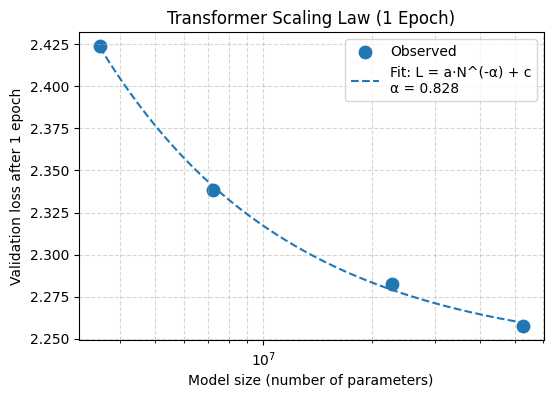

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

model_names = list(rnn_results_all.keys())
N = np.array([rnn_results_all[k]["params_M"] * 1e6 for k in model_names])
L = np.array([rnn_results_all[k]["val_loss"] for k in model_names])

def scaling_law(N, a, alpha, c):
    return a * N**(-alpha) + c
p0 = [1.0, 0.05, min(L)]


params, _ = curve_fit(scaling_law, N, L, p0=p0, maxfev=10000)
a_fit, alpha_fit, c_fit = params

print(f"Fitted parameters:")
print(f"a     = {a_fit:.4f}")
print(f"alpha = {alpha_fit:.4f}")
print(f"c     = {c_fit:.4f}")


plt.figure(figsize=(6,4))
plt.scatter(N, L, s=80, label="Observed")

N_fit = np.logspace(np.log10(N.min()), np.log10(N.max()), 300)
L_fit = scaling_law(N_fit, a_fit, alpha_fit, c_fit)

plt.plot(
    N_fit, L_fit, "--",
    label=f"Fit: L = a·N^(-α) + c\nα = {alpha_fit:.3f}"
)

plt.xscale("log")
plt.xlabel("Model size (number of parameters)")
plt.ylabel("Validation loss after 1 epoch")
plt.title("Transformer Scaling Law (1 Epoch)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()
